# Object Localization Model
An object localization model (part 1 of workflow). The model predicts a bounding box over catch basins via a convolutional neural network.

* Input - 180x180x3 numpy array (RGB image of catch basin)
* Output - 4 values (`xmin`, `ymin`, `xmax`, `ymax`)

## Imports

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.losses import CategoricalCrossentropy
from PIL import Image, ImageDraw
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from config import object_localizer_image_size as image_size

## Preparation of Data

Create dataframe by parsing the PASCAL VOC (XML) files.
Each file contains data about the coordinates of bounding
boxes, width, height, file name, etc. for each image in `data/`.

In [3]:
columns = ("filename", "name", "width", "height", "xmin", "ymin", "xmax", "ymax")
rows = []

for path in pathlib.Path('data').glob('*.xml'):
    tree = ET.parse(str(path))
    root = tree.getroot()
    filename = root.find("filename").text
    for obj in root.findall("object"):
        row = []
        row.append(filename)
        row.append(obj.find("name").text)
        row.append(int(root.find("size").find("width").text))
        row.append(int(root.find("size").find("height").text))
        for i in obj.find("bndbox"):
            row.append(int(i.text))
        rows.append(row)

df = pd.DataFrame(rows, columns=columns)
df.head()

,filename,name,width,height,xmin,ymin,xmax,ymax
0,01_Clear.JPG,clear,543,708,266,420,362,460
1,02_Partial.JPG,partial,621,769,202,443,307,490
2,03_Partial.JPG,partial,594,797,292,535,428,579
3,04_Clear.JPG,clear,531,779,81,462,210,550
4,05_Partial.JPG,partial,537,678,153,519,291,578


The bounding box coordinates are then normalized.

In [3]:
normalized_df = df.copy()
normalized_df['xmin'] /= normalized_df['width']
normalized_df['xmax'] /= normalized_df['width']
normalized_df['ymin'] /= normalized_df['height']
normalized_df['ymax'] /= normalized_df['height']
normalized_df.head()

,filename,name,width,height,xmin,ymin,xmax,ymax
0,01_Clear.JPG,clear,543,708,0.489871,0.593220,0.666667,0.649718
1,02_Partial.JPG,partial,621,769,0.325282,0.576073,0.494364,0.637191
2,03_Partial.JPG,partial,594,797,0.491582,0.671267,0.720539,0.726474
3,04_Clear.JPG,clear,531,779,0.152542,0.593068,0.395480,0.706033
4,05_Partial.JPG,partial,537,678,0.284916,0.765487,0.541899,0.852507


The data from `normalized_df` is transformed into the `X` (contains images) and `Y` (contains bounding boxes) numpy arrays.

In [4]:
X = np.zeros((len(normalized_df), *image_size, 3))
Y = np.zeros((len(normalized_df), 4))

for i, row in normalized_df.iterrows():
    img = load_img(pathlib.Path('data', row['filename']), target_size=image_size)
    X[i] = img_to_array(img)
    Y[i, 0] = row['xmin']
    Y[i, 1] = row['ymin']
    Y[i, 2] = row['xmax']
    Y[i, 3] = row['ymax']

## Construction of the Model
A convolutional neural network is constructed. A `Rescaling` Layer is added to normalize `RGB` values. 

In [19]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(*image_size, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(4, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

## Training

In [20]:
epochs = 10

history = model.fit(
    x=X,
    y=Y,
    validation_split=0.2,
    epochs=epochs,
)

Epoch 1/10
3/3 [==============================] - 2s 441ms/step - loss: 0.6884 - accuracy: 0.1625 - val_loss: 0.6639 - val_accuracy: 0.9048
Epoch 2/10
3/3 [==============================] - 1s 381ms/step - loss: 0.6280 - accuracy: 0.8875 - val_loss: 0.6561 - val_accuracy: 0.9048
Epoch 3/10
3/3 [==============================] - 1s 379ms/step - loss: 0.6357 - accuracy: 0.8875 - val_loss: 0.6483 - val_accuracy: 0.9048
Epoch 4/10
3/3 [==============================] - 1s 362ms/step - loss: 0.6229 - accuracy: 0.8875 - val_loss: 0.6587 - val_accuracy: 0.9048
Epoch 5/10
3/3 [==============================] - 1s 407ms/step - loss: 0.6232 - accuracy: 0.8875 - val_loss: 0.6542 - val_accuracy: 0.9048
Epoch 6/10
3/3 [==============================] - 1s 389ms/step - loss: 0.6189 - accuracy: 0.8875 - val_loss: 0.6437 - val_accuracy: 0.9048
Epoch 7/10
3/3 [==============================] - 1s 399ms/step - loss: 0.6194 - accuracy: 0.8875 - val_loss: 0.6434 - val_accuracy: 0.9048
Epoch 8/10
3/3 [====

## Training Analysis
See how the model did. 

Collect metrics.

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Graph the metrics

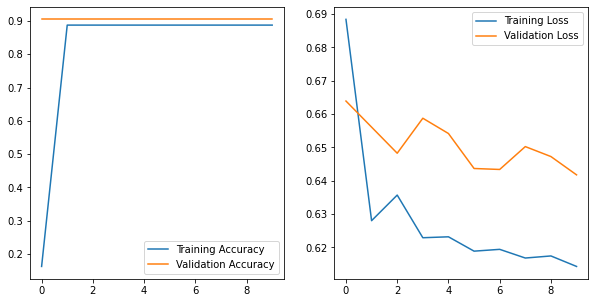

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

Print out metrics such as accuracy and loss.

In [23]:
print('accuracy:', acc[-1], 'val_accuracy:', val_acc[-1])
print('loss', loss[-1], 'val_loss:', val_loss[-1])

accuracy: 0.887499988079071 val_accuracy: 0.9047619104385376
loss 0.614287257194519 val_loss: 0.6417605876922607


A quick test on an unseen image.

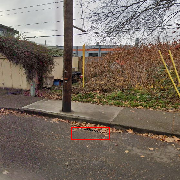

In [24]:
img = load_img('validation_images/GSV_Lents/06_Blocked.JPG', target_size=image_size)
img_arr = img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
pred = model.predict(img_arr)
bbox = pred[0]
bbox *= image_size[0]
draw = ImageDraw.Draw(img)
draw.rectangle(bbox, outline='red', width=1)
img

## Saving the Model
The model is saved so that it can be loaded again for future use.

In [25]:
saved_models = pathlib.Path.cwd() / 'saved_models' / 'object_localizer_models'
if not saved_models.exists():
    saved_models.mkdir()

The following format is used for saving: `model-{num}-{acc}-{val_acc}-{loss}-{val_loss}`

In [26]:
fmt = f'{round(acc[-1], 2)}-{round(val_acc[-1], 2)}-{round(loss[-1], 2)}-{round(val_loss[-1], 2)}'
    
model_dirs = list(saved_models.iterdir())
if len(model_dirs) == 0: 
    model.save(saved_models / f'model-0-{fmt}')
else:
    num_strs = map(lambda x: x.name[len("model-")], saved_models.iterdir())
    num = max(list(map(lambda x: int(x), num_strs))) + 1
    model.save(saved_models / f'model-{num}-{fmt}')

INFO:tensorflow:Assets written to: C:\Users\SA\Desktop\Programming\projects\catch_basin_classifier\saved_models\object_localizer_models\model-2-0.89-0.9-0.61-0.64\assets
